#Predicting Human Transcription start sites

In this exercise we will work with a set of human promoter sequences and try to predict whether a location is a transcription start site (TSS). The neural network will take a "window" around a position in the DNA and predict whether the position is a transcription start site or not (binary classification).

We will learn how to encode a DNA sequence for a neural network and how to use one-dimensional convolution.

##Exercise:

1. Is the network over-fitting?
2. Compare a fully connected model to a convolution model. Which is best?
3. Try to improve the convolution model by changing
 *   the size of the input
 *   the parameters
 *   the number of hidden units
 *   or the number of hidden layers.
4. Do you think the performance of the network is impressive/good/useless?




## Data download and installation of biopython

Data consists of sequences from EPD
https://epd.epfl.ch/get_promoters.php

999 bases before the TSS and 1000 bases after

They are available as a compressed fasta file

For negative examples we will use random positions in the same sequences

In [1]:
%%bash
# Download data in fasta format
if [ -e EPD_all_hg38.fa ]; then echo "Already downloaded"
else
  wget -q http://people.binf.ku.dk/krogh/data/EPD/EPD_all_hg38.fa.gz
  gunzip EPD_all_hg38.fa.gz
fi
ls -lh


Already downloaded
total 60M
-rw-r--r-- 1 root root  60M Mar 16 13:10 EPD_all_hg38.fa
drwxr-xr-x 1 root root 4.0K May  3 13:42 sample_data


In [2]:
# Install biopython
!pip -q install biopython

## Prepare data for neural network

In [3]:
import torch

# These paramters specify the window size (before/after TSS)
win_before = 100
win_after = 20
# The total window size
win_len = win_before+win_after

# Total number of promoter examples is around 29000
# For each positive example, we generate Nneg netagive examples
# from random places in the sequences
# Total number of examples is therefore about 29000*(1+Nneg)
Nneg=1

# The data are separated into train and validation using these fractions
# SMALLER SIZES => FASTER LEARNING
train_fraction = 0.5
validation_fraction = 0.05
#train_fraction = 0.8
#validation_fraction = 1-train_fraction

# The size of the mini-batches
batch=256

# Magic needed to use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


In [4]:
import re # regular expressions
import random # random numbers
from Bio import SeqIO
from torch.utils.data import Dataset,DataLoader


def one_hot_dna(seq):
    ''' Takes a string (or BioPython sequence like "dna.seq")
        and converts it to a 2D tensor [4,L) of one-hot encoding
        Character n is encoded as 0,0,0,0
    '''
    # This is a dictionary for each letter
    hot_dna = {"A":(1.,0.,0.,0.), "C":(0.,1.,0.,0.), "G":(0.,0.,1.,0.), "T":(0.,0.,0.,1.), "N":(0.,0.,0.,0.)}
    return torch.tensor([ hot_dna[c] for c in seq ])


class DNA_Dataset(Dataset):
  ''' 
  This class is used for the promoter data set. You specify a fasta file,
  the window around the TSS to use, and how many negative examples to select
  for each positive example.
  '''
  def __init__(self, fastafile, wbefore, wafter, pos=1000, n_negative=1):
    '''
    fastafile contains sequences with a TSS at position pos
    wbefore, wafter are the left and right window sizes
    n_negative is the number of random negative examples chosen in each
    sequence
    '''

    # The TSS is at pos (e.g. =1000), so we extract from pos-wbefore
    # to pos+wafter
    tss = pos-wbefore
    wlen=wbefore+wafter

    # Initialize empty lists of inputs and targets
    self.inputs = []
    self.targets = []

    # Use biopython to read and parse fasta file
    for seq_record in SeqIO.parse(fastafile, "fasta"):
      # last position where you can start window
      max = len(seq_record.seq)-wlen-1
      # This loop first pics a sequence at the TSS and then at n_negative random positions
      for i in range(n_negative+1):
        k = tss
        if i==0:
          target=torch.tensor(1.)
        else: # Pick a random position as negative example
          target=torch.tensor(0.)
          while k==tss: k = random.randint(0,max)

        # Get the substring from k to k+wlen. Make it upper case
        s = str(seq_record.seq[k:k+wlen]).upper()

        # Skip if it contains non-ACGT
        if re.match("[^ACGT]",s) is None:
          # Convert to one-hot and append example to lists
          self.inputs.append(one_hot_dna(s))
          self.targets.append(target)
        else:
          print("This seq contains non-ACTG",s)

  # This function is mandatory. This is where an example is returned
  def __getitem__(self, index):
    return self.inputs[index],self.targets[index]

  def __len__(self):
    return len(self.targets)





In [5]:
# Read and prepare data
all_data = DNA_Dataset("EPD_all_hg38.fa",win_before,win_after, n_negative=Nneg)

# Split data at random into test and train
Ntot=len(all_data)
Ntrain=int(train_fraction*Ntot)
Nvalidation=int(validation_fraction*Ntot)

# The data are randomly divided into train and validation sets
indices = torch.randperm(Ntot)
train_subset = torch.utils.data.Subset(all_data, indices[:Ntrain])
validation_subset = torch.utils.data.Subset(all_data, indices[Ntrain:Ntrain+Nvalidation])

# The dataloader automates the use of minibatches
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch)
validation_loader = torch.utils.data.DataLoader(validation_subset, batch_size=batch)

# Sometimes it is convenient to work with all test data as one large tensor
validation_data =  torch.cat([validation_subset[i][0].unsqueeze(0) for i in range(Nvalidation)]).to(device)
validation_target =  torch.cat([validation_subset[i][1].unsqueeze(0) for i in range(Nvalidation)]).flatten()



## Initialization of parameters for the neural network

In [6]:


# Model. Fully connected have two hidden layers:
n_hidden1 = 10
n_hidden2 = 5
convolution=False # Change to True to get convolution net

# Convolution model has a convolution layer and one hidden layer with n_hidden1 units
#convolution=True # Change to false to get FC net
nchannel = 10
kernel_size = 4

nepochs = 50

weight_decay=1.e-5



## Neural Network 

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionNet(nn.Module):
  def __init__(self,win_len,nhidden=10,channels=10,kernel_size=4 ):
    super(ConvolutionNet, self).__init__()
    # The number of output units from the convolution
    self.n_conv_out = channels*(win_len-kernel_size+1)
    # It is a 2D kernel, because the input is (win_len,4)
    # Alternatively, one could use a 1D tensor of size 4*win_len and 1D
    # convolution with stride 4
    # kernel_size is the number of nucleotides in the convolution
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels,
                           kernel_size=(kernel_size,4), stride=1, padding=0)
    # A fully connected layer after the convolution layer
    self.fc1 = nn.Linear(in_features=self.n_conv_out, out_features=nhidden)
    # Final linear output
    self.fc2 = nn.Linear(in_features=nhidden, out_features=1)
     
  def forward(self, x):
    # ReLU activation functions are used on the hidden layers
    x = F.relu(self.conv1(x.unsqueeze(1))).view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    return self.fc2(x)

# If convolution is True, the above class is used. Otherwise a standard
# feed-forward network is used
if convolution:
  model = ConvolutionNet(win_len,nhidden=n_hidden1, channels=nchannel,
                           kernel_size=kernel_size).to(device)
else:
  model = torch.nn.Sequential(
    torch.nn.Flatten(),   # This is needed to make the input tensor one-dimensional
    torch.nn.Linear(win_len*4, n_hidden1),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden1, n_hidden2),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden2, 1)
  ).to(device)


## Train

In [8]:

optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

# BCEWithLogitsLoss is used with linear output and corresponds to sigmoid
# activation followed by binary cross entropy loss
lossfunc = torch.nn.BCEWithLogitsLoss()

# Move target values to GPU
v_target = validation_target.to(device)

# Save performace values in a dictionary with lists
performance = {'Epoch':[],'Train loss':[],'Train wrong':[],'Test loss':[],'Test wrong':[]}

for epoch in range(nepochs):
  performance['Epoch'].append(epoch)
  performance['Train loss'].append(0)
  performance['Train wrong'].append(0)

  for x,t in train_loader:
    optimizer.zero_grad()
    x = x.to(device)
    t = t.to(device)*1.0
    y = model(x).flatten()
    loss = lossfunc(y,t)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      performance['Train loss'][-1] += loss.item()*len(y) / Ntrain
      # Counting the number of outputs that are correct (threshold 0.5)
      y=torch.sigmoid(y)
      performance['Train wrong'][-1] += (2*t-1).mul(2*y-1.).lt(0.).sum().item()/Ntrain
    c=0.
  with torch.no_grad():
    y = model(validation_data).flatten()
    performance['Test loss'].append(lossfunc(y,v_target).item())
    # Counting the number of outputs that are wrong
    y=torch.sigmoid(y)
    # This is used to count the number of errors (target-0.5)*(y-0.5)<0 if prediction is wrong
    performance['Test wrong'].append( (v_target-0.5).mul(y-0.5).lt(0.).sum().item()/Nvalidation)

  if (epoch+1)%5 == 0:
    print(epoch+1,performance['Train wrong'][-1],performance['Test wrong'][-1])


5 0.19903371849449272 0.19736397431564717
10 0.18301912291371042 0.19297059817505915
15 0.17494425299006688 0.19601216627238932
20 0.16460571660247308 0.20074349442379183
25 0.15980809514156363 0.20175735045623522
30 0.15555105074667205 0.2000675904021629
35 0.15237516048381644 0.19837783034809056
40 0.15024663828637067 0.19972963839134844
45 0.14919927022096083 0.20175735045623522
50 0.14730725048989798 0.20243325447786414


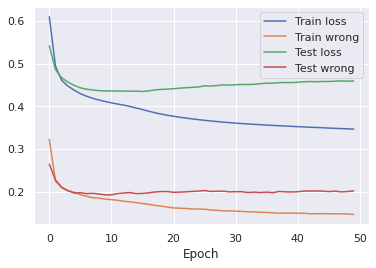

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()
df = pd.DataFrame.from_dict(performance).set_index('Epoch')
sns.lineplot(data=df,dashes=False)
plt.show()


## ROC curve

In [10]:
import numpy
def ROCandRoll(target,output):
  '''
  Function takes a tensor of target values (must be 0/1) and prediction
  outputs.
  Returns a dict with FP rate, TP rate and ...
  '''
  with torch.no_grad():
    N = len(target)
    Npos = target.sum()
    Nneg = N-Npos
    z,order = torch.sort(output)
    # Reordering targets the same way
    target = target[order]
    # Cummulative count of targets=1 are FN counts
    TP = Npos - torch.cumsum(target,dim=0)
    FP = torch.arange(N,0,step=-1)-TP
    roc = {'TP rate':(TP/Npos).numpy(), 'FP rate':(FP/Nneg).numpy(),
           'Sorted outputs': z.numpy(), 'Sorted targets':target.numpy()}
    roc['AUC'] = sum([0.5*(roc['TP rate'][i]+roc['TP rate'][i+1])*
               (roc['FP rate'][i]-roc['FP rate'][i+1]) for i in range(N-1)])
    return roc


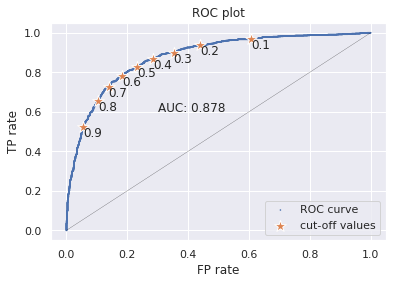

In [11]:

# ROC curve
with torch.no_grad():
  # Get output for all validation data
  y = torch.sigmoid(model(validation_data).flatten()).cpu()
  roc = ROCandRoll(validation_target,y)

sns.set()
# Lineplot very slow
#sns.lineplot(data=roc, x='FP rate', y='TP rate', linewidth=2).set_title('ROC plot')
sns.scatterplot(data=roc, x='FP rate', y='TP rate',marker='.',s=10,
                edgecolor = 'none',label='ROC curve').set_title('ROC plot')
plt.plot([0., 1.], [0., 1.], linewidth=0.2, color='black')
plt.text(0.3, 0.6, 'AUC: '+ "%0.3f" % roc['AUC'],horizontalalignment='left')

# Decorate ROC curve with threhold values
cut=0.1
points=[[],[]]
for i in range(Nvalidation):
  if roc['Sorted outputs'][i]>cut:
    points[0].append(roc['FP rate'][i])
    points[1].append(roc['TP rate'][i])
    plt.text(roc['FP rate'][i], roc['TP rate'][i], "%0.1f"%cut,
             horizontalalignment='left',verticalalignment='top')
    cut += 0.1
sns.scatterplot(x=points[0],y=points[1],marker="*",s=150,alpha=1,label='cut-off values')
plt.show()